<a href="https://colab.research.google.com/github/dookda/cmu_water_balance/blob/main/watbalance_multisource_sltm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# ตรวจสอบและเริ่มต้นการเชื่อมต่อ GEE
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate() # หากยังไม่ได้ยืนยันตัวตน ให้ทำการยืนยัน
    ee.Initialize(project="ee-sakda-451407")   # แล้วเริ่มต้นการเชื่อมต่ออีกครั้ง


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import ee # ต้อง import ee และ ee.Initialize() ก่อนใช้งาน


# เริ่มด้วยการกำหนดขอบเขตพื้นที่ศึกษา (ลุ่มน้ำ) (ให้แทนที่ด้วย asset หรือ GeoJSON)
# โหลดข้อมูลขอบเขตลุ่มน้ำจาก GEE asset
basin = ee.FeatureCollection('projects/ee-sakda-451407/assets/nan_extent')

# กำหนดช่วงเวลาที่ต้องการข้อมูล
start, end = '2010-01-01', '2022-12-31'

image_counts = {'P': 0, 'ET': 0, 'SM': 0} # สร้าง dictionary เพื่อเก็บจำนวนภาพของแต่ละชุดข้อมูล

def get_ts(col_id, band, name, scale=10000, agg_factor=1):
    """
    ฟังก์ชันสำหรับดึงข้อมูลอนุกรมเวลาจาก GEE, คำนวณค่าเฉลี่ยเชิงพื้นที่, และแปลงเป็น FeatureCollection
    """
    # ดึงชุดข้อมูลภาพ (Image Collection) ตาม ID ที่ระบุ
    ic = ee.ImageCollection(col_id) \
            .filterDate(start, end) \
            .filterBounds(basin)

    # นับและเก็บจำนวนภาพทั้งหมดในชุดข้อมูล
    count = ic.size().getInfo()
    image_counts[name] = count

    # กรณีที่ข้อมูลต้องมีการปรับค่า (เช่น ข้อมูล 8 วันให้เป็นรายวัน)
    if agg_factor != 1:
        # ปรับค่าในแต่ละภาพ เช่น หารด้วย 8 สำหรับข้อมูล ET ของ MODIS ที่เป็นผลรวม 8 วัน
        ic = ic.map(lambda img: img.select(band).divide(agg_factor)
                                .copyProperties(img, ['system:time_start']))
    def to_feature(img):
        """
        ฟังก์ชันย่อยสำหรับแปลง Image แต่ละภาพให้เป็น Feature
        """
        # คำนวณค่าเฉลี่ยของ pixel ในขอบเขตพื้นที่ศึกษา
        mean = img.reduceRegion(
            reducer=ee.Reducer.mean(), # ใช้ reducer ค่าเฉลี่ย
            geometry=basin.geometry(), # กำหนดขอบเขตในการคำนวณ
            scale=scale,               # กำหนดความละเอียดของข้อมูล (pixel size)
            maxPixels=1e13             # กำหนดจำนวน pixel สูงสุดที่อนุญาตให้คำนวณ
        )
        # สร้าง Feature ใหม่ที่มี property เป็น 'date' และค่าเฉลี่ยของ band ที่สนใจ
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-dd'),
            name: mean.get(band)
        })
    # ใช้ฟังก์ชัน to_feature กับทุกภาพใน Image Collection เพื่อแปลงเป็น FeatureCollection
    return ic.map(to_feature)

# ดึงข้อมูลจากชุดข้อมูลต่างๆ บน GEE

# ข้อมูลน้ำฝน (Precipitation)
p_fc  = get_ts('UCSB-CHG/CHIRPS/DAILY', 'precipitation', 'P', scale=5000)
# ข้อมูลการคายระเหย (Evapotranspiration) - MOD16A2 เป็นข้อมูลผลรวมทุก 8 วัน
et_fc = get_ts('MODIS/061/MOD16A2GF', 'ET', 'ET', scale=500)
# ข้อมูลความชื้นในดิน (Soil Moisture)
sm_fc = get_ts('NASA/SMAP/SPL3SMP_E/005', 'soil_moisture_am', 'SM', scale=10000)

# แสดงจำนวนภาพที่ดึงมาได้ของแต่ละชุดข้อมูล
print(f"ข้อมูลน้ำฝน (CHIRPS): {image_counts['P']} ภาพ (รายวัน)")
print(f"ข้อมูลการคายระเหย (MODIS): {image_counts['ET']} ภาพ (ทุก 8 วัน)")
print(f"ข้อมูลความชื้นในดิน (SMAP): {image_counts['SM']} ภาพ (รายวัน)")


ข้อมูลน้ำฝน (CHIRPS): 4747 ภาพ (รายวัน)
ข้อมูลการคายระเหย (MODIS): 598 ภาพ (ทุก 8 วัน)
ข้อมูลความชื้นในดิน (SMAP): 2747 ภาพ (รายวัน)


In [4]:
# ประมวลผลข้อมูล
def fc_to_df(fc):
    """
    ฟังก์ชันสำหรับแปลง FeatureCollection ที่ได้จาก GEE เป็น Pandas DataFrame
    """
    feats = fc.getInfo()['features'] # ดึงข้อมูล feature ทั้งหมดออกมา
    props = [f['properties'] for f in feats] # ดึงเฉพาะส่วน properties ของแต่ละ feature
    return pd.DataFrame(props) # สร้าง DataFrame จาก list ของ properties

# สร้าง DataFrame หลักโดยการรวม DataFrame ของแต่ละตัวแปรเข้าด้วยกัน
# ใช้ 'date' เป็น key ในการรวมข้อมูล
df = (
    fc_to_df(p_fc)
      .merge(fc_to_df(et_fc), on='date', how='inner') # ใช้ inner join เพื่อเอาเฉพาะวันที่มีข้อมูลครบทุกตัว
      .merge(fc_to_df(sm_fc), on='date', how='inner')
)

print(f"ขนาดของ DataFrame หลังรวมข้อมูล: {df.shape}")

# จัดการข้อมูลเบื้องต้น
df['date'] = pd.to_datetime(df['date']) # แปลงคอลัมน์ 'date' เป็นชนิดข้อมูล datetime
df = df.sort_values('date').reset_index(drop=True) # เรียงข้อมูลตามวันที่และรีเซ็ต index

# การสร้าง Feature (Feature Engineering)

# คำนวณค่าการเปลี่ยนแปลงความชื้นในดิน (ΔSM) และค่าน้ำท่าโดยประมาณ (R) จากสมการสมดุลน้ำ R = P - ET - ΔSM
df['dSM'] = df['SM'].diff().fillna(0) # คำนวณ ΔSM คือผลต่างของความชื้นในดินเทียบกับวันก่อนหน้า
df['R']   = df['P'] - df['ET'] - df['dSM'] # คำนวณน้ำท่า (Runoff)

# เพิ่ม features ที่เกี่ยวกับเวลา (Temporal features)
df['day_of_year'] = df['date'].dt.dayofyear # เพิ่มคอลัมน์ลำดับของวันในรอบปี (1-366)
df['month'] = df['date'].dt.month           # เพิ่มคอลัมน์เดือน (1-12)

# print df
print(df.head())

# เพิ่ม features ที่เป็นค่าสถิติย้อนหลัง (Rolling statistics)
df['P_7d_avg'] = df['P'].rolling(window=7).mean()
df['ET_7d_avg'] = df['ET'].rolling(window=7).mean()

# เตรียมข้อมูลสำหรับป้อนเข้าโมเดล

# เลือกเฉพาะ features ที่เป็นตัวเลขและตัวแปร target เพื่อใช้ในโมเดล
# ตัวอย่างนี้จะทำนาย R (น้ำท่า)

# features = ['P','ET','dSM'] # ตัวอย่างชุด features แบบที่ 1
features = ['P','ET','dSM','day_of_year'] # กำหนด features ที่จะใช้เป็น Input (ตัวแปรต้น)

print(features)

target = 'R' # กำหนด 'R' (น้ำท่า) เป็นตัวแปรตาม (Target)
data = df[features + [target]].dropna().values # สร้าง array ของข้อมูลจาก features และ target ที่เลือก และลบแถวที่มีค่าว่าง (NaN)

print(f"ขนาดของข้อมูลที่พร้อมสำหรับโมเดล: {data.shape}")

# ส่วนต่อไปจะเป็นการสร้าง, ฝึกสอน, และประเมินผลโมเดล LSTM (ไม่ได้รวมอยู่ในโค้ดต้นฉบับ)

ขนาดของ DataFrame หลังรวมข้อมูล: (345, 4)
          P       date          ET        SM       dSM           R  \
0  1.141877 2015-04-07  212.127035  0.272058  0.000000 -210.985158   
1  0.000000 2015-04-15  217.791430  0.311467  0.039408 -217.830838   
2  1.167034 2015-04-23  235.833514  0.388334  0.076867 -234.743348   
3  0.036198 2015-05-01  241.613586  0.323939 -0.064395 -241.512994   
4  6.884759 2015-05-09  267.669735  0.388327  0.064388 -260.849363   

   day_of_year  month  
0           97      4  
1          105      4  
2          113      4  
3          121      5  
4          129      5  
['P', 'ET', 'dSM', 'day_of_year']
ขนาดของข้อมูลที่พร้อมสำหรับโมเดล: (345, 5)


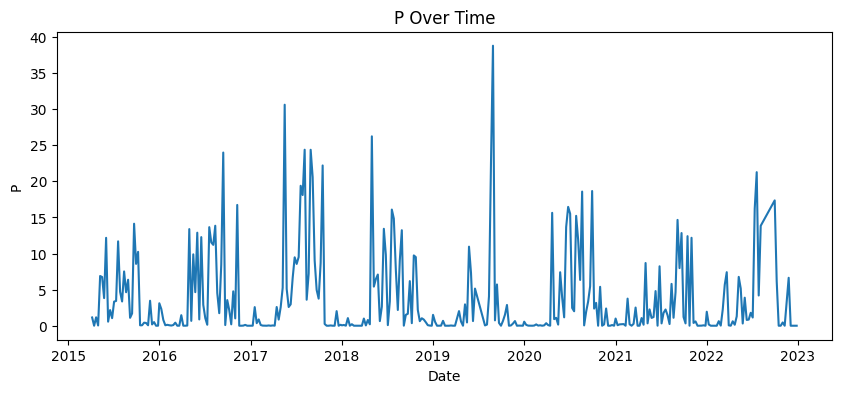

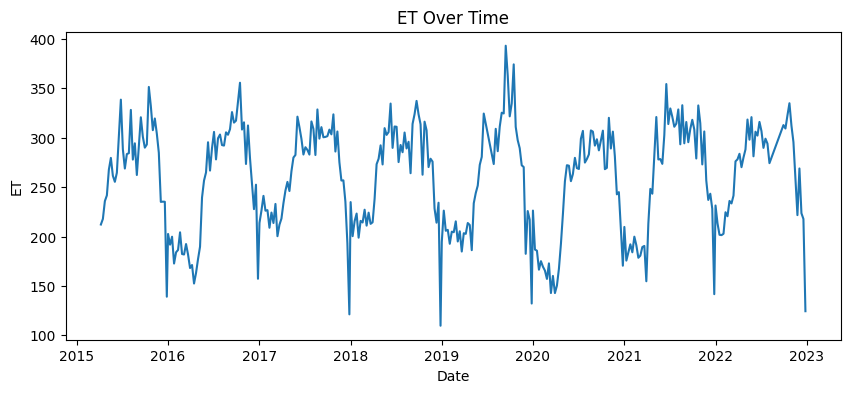

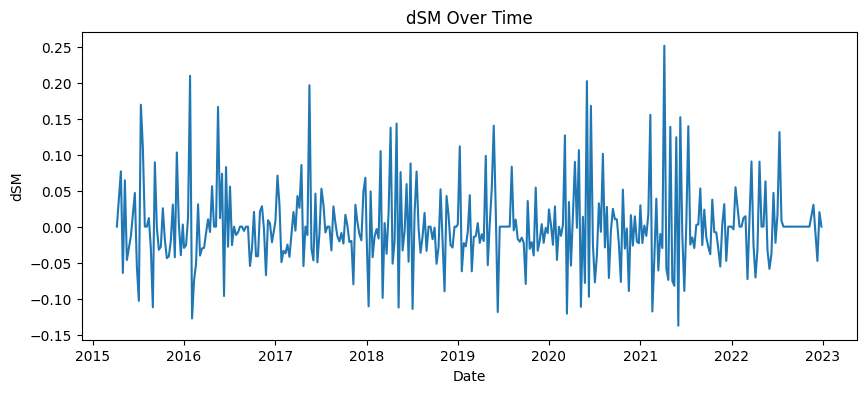

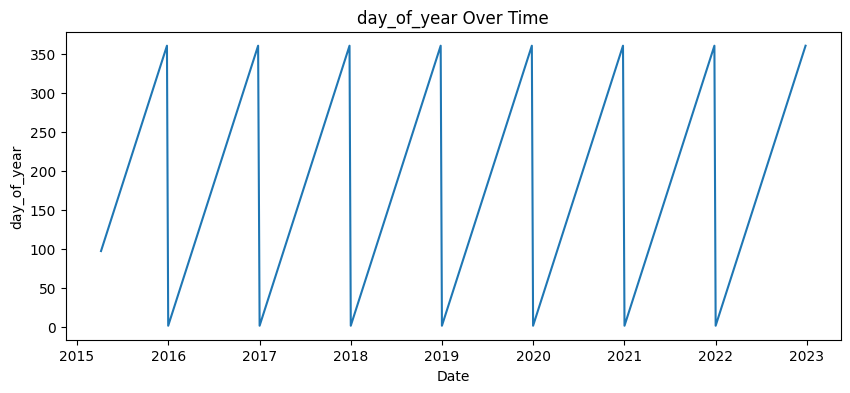

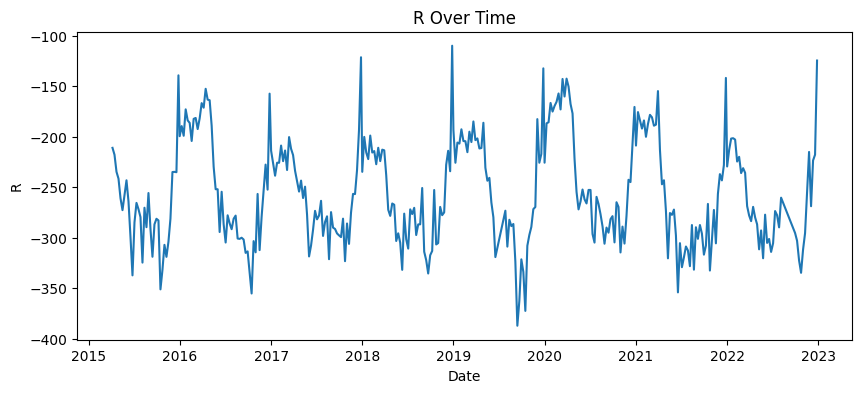

In [13]:
# แสดงกราฟข้อมูลของทุกปัจจัย
for feature in features:
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df[feature])
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} Over Time')
    plt.show()

# show target chart
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df[target])
plt.xlabel('Date')
plt.ylabel(target)
plt.title(f'{target} Over Time')
plt.show()


In [8]:
# 2. SCALE AND SEQUENCE
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# create sequences
sequence_length = 32  # use last 30 days to predict next-day runoff
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, :-1])  # all features
    y.append(data_scaled[i+sequence_length, -1])     # target column
X, y = np.array(X), np.array(y)

# train/val/test split (70/15/15)
n = len(X)
train_end = int(n*0.7)
val_end   = int(n*0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]



In [9]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),
                      input_shape=(sequence_length, len(features))))
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True))
model.add(LSTM(32))
model.add(Dense(32,
                activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,241 (383.75 KB)

 Trainable params: 98,241 (383.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.1632 - val_loss: 0.0302
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0404 - val_loss: 0.0134
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0390 - val_loss: 0.0097
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - val_loss: 0.0225
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0297 - val_loss: 0.0087
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0183 - val_loss: 0.0098
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0186 - val_loss: 0.0132
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195 - val_loss: 0.0114
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0263 - val_loss: 0.0195
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0212 - val_loss: 0.0115
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0153 - val_loss: 0.0104
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

In [ ]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 1
model = Sequential()
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.2,
               input_shape=(sequence_length, len(features))))
model.add(LSTM(32,
               activation='tanh',
               dropout=0.2,
               recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

In [ ]:
# 3. BUILD & TRAIN MULTIVARIATE LSTM 2

model = Sequential()
model.add(LSTM(64,
               activation='tanh',
               return_sequences=True,
               dropout=0.2,
               recurrent_dropout=0.2,
               input_shape=(sequence_length, len(features))))
model.add(LSTM(32,
               activation='tanh',
               dropout=0.2,
               recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

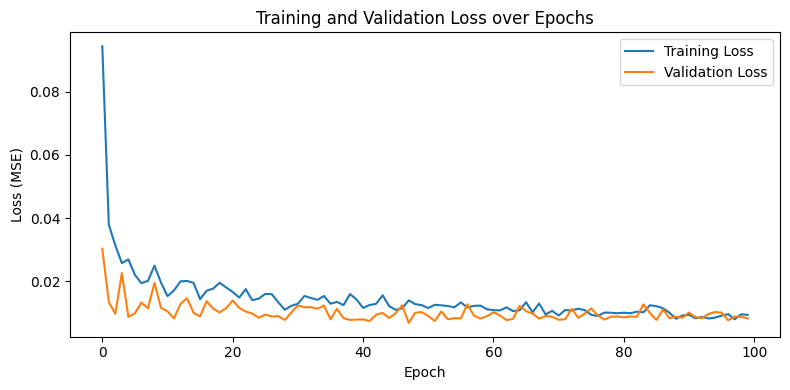

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


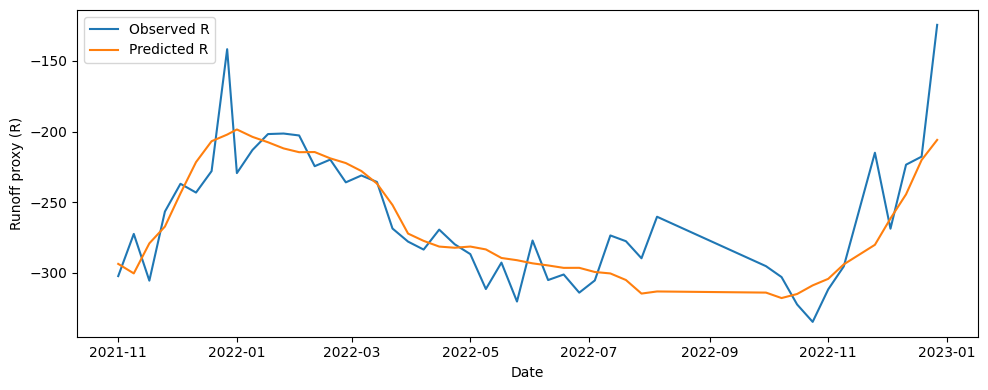

Test RMSE: 24.613, MAE: 17.659, R²: 0.709


In [11]:
# 4. EVALUATE & INVERSE-SCALE PREDICTIONS
# predict
y_pred = model.predict(X_test)

# we need to inverse-scale only the target dimension
# so rebuild full array placeholders
y_test_full  = np.zeros((len(y_test), data.shape[1]))
y_pred_full  = np.zeros_like(y_test_full)
y_test_full[:, -1] = y_test
y_pred_full[:, -1] = y_pred.flatten()

# inv_test = scaler.inverse_transform(y_test_full)[:,-1]
# inv_pred = scaler.inverse_transform(y_pred_full)[:,-1]

# compute simple metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
# y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

y_true_inv = scaler.inverse_transform(y_test_full)[:,-1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:,-1]

mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100 if np.all(y_true_inv != 0) else np.nan

# rmse = np.sqrt(mean_squared_error(inv_test, inv_pred))
# mae  = mean_absolute_error(inv_test, inv_pred)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['date'].values[-len(y_true_inv):], y_true_inv, label='Observed R')
plt.plot(df['date'].values[-len(y_pred_inv):], y_pred_inv, label='Predicted R')
plt.xlabel('Date'); plt.ylabel('Runoff proxy (R)');
plt.legend(); plt.tight_layout(); plt.show()

print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")